In [2]:
import pandas as pd
from biodatatools.utils.common import json_load
from mphelper import ProcessWrapPool
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pybedtools
import itertools
from collections import defaultdict
from biodata.delimited import DelimitedWriter
from pathlib import Path

In [3]:
font_dir = Path.cwd().parent / "font"
for font in ["Arial.ttf", "Arial_Bold.ttf"]:
    matplotlib.font_manager.fontManager.addfont(font_dir / font)
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9

In [9]:
PROJECT_DIR_d = "/home/yc2553/projects/HEA/databases/"
PROJECT_DIR_d2 = "/fs/cbsuhy02/storage/yc2553/yc2553/databases/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/"
PROJECT_DIR_o2 = "/home/yc2553/projects/HEA/output/"

# Overlap with TREs

In [ ]:
# Calculate the proportion of SNPs overlapping with tissue-specific and non-tissue-specific elements at a given PIP cutoff
# Generate a similar figure as Fig.1b from https://www.nature.com/articles/s41586-021-03446-x

In [5]:
cutoff = 0.05
extension = 1000
p = "divergent"
d = "distal"
outdir = f"{PROJECT_DIR_o}LDSC/annots/{cutoff}_{extension}"

In [13]:
data_types = ["GWAS", "eQTL"]
# We observed similar trends using either method; show FINEMAP in the paper 
# methods = ["FINEMAP", "SUSIE"]
methods = ["FINEMAP"]

In [10]:
cdict = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/color_codes.json")

In [11]:
ts = ["_".join(t.split(" ")) for t in cdict] + ["Non_tissue_specific"]

In [14]:
def get_overlaps(snp_bed, TRE_bed, outputfile):
	b1 = pybedtools.BedTool(snp_bed)
	b2 = pybedtools.BedTool(TRE_bed)
	overlaps = b1.intersect(b2, wao=True)
	results = []
	for i in overlaps:
		chrom, start, end, snp  = i.fields[:4]
		trait, pip  = i.fields[-6:-4]
		in_tre = True if int(i.fields[-1]) > 0 else False
		results.append([chrom, start, end, snp, trait, float(pip), in_tre])
	df = pd.DataFrame(results, columns=["chrom", "start", "end", "snp", "trait", "pip", "in_tre"])
	df.to_csv(outputfile, sep="\t", index=False)

In [16]:
pwpool = ProcessWrapPool(10)

for data_type, method in itertools.product(data_types, methods):
	if data_type == "GWAS":
		snp_bed = f"{PROJECT_DIR_d2}papers/38014075/GWAS/UKBB_94traits_release1_filtered_{method}_hg38.bed.gz"
	else:
		snp_bed = f"{PROJECT_DIR_d2}papers/38014075/eQTL/GTEx_49tissues_release1_maximum_{method}_hg38.bed.gz"
	for t in ts:
		TRE_bed = f"{outdir}/{p}_{d}_{t}.bed"
		outputfile = f"{PROJECT_DIR_o}temp/{data_type}_{p}_{d}_{t}_{method}.txt"
		pwpool.run(get_overlaps, args=[snp_bed, TRE_bed, outputfile])

In [20]:
len(pwpool.get())

32

In [21]:
pwpool.close()

In [22]:
def get_props(inputfile):
	cutoffs = np.linspace(0.001, 1, 100)
	df = pd.read_table(inputfile)
	results = []
	for trait in set(df["trait"]):
		df2 = df[df["trait"]==trait]
		for cutoff in cutoffs:
			n_total = len(set(df2[df2["pip"]>cutoff]["snp"]))
			n_in_tre = len(set(df2[(df2["pip"]>cutoff) & (df2["in_tre"]==True)]["snp"]))
			prop = n_in_tre/n_total * 100 if n_total > 0 else np.nan
			results.append([cutoff, trait, n_total, n_in_tre, prop])
	df = pd.DataFrame(results, columns=["cutoff", "trait", "n_total", "n_in_tre", "prop"])
	return df

In [23]:
pwpool = ProcessWrapPool(10)

map_dict = {}
for data_type, method in itertools.product(data_types, methods):
	for t in ts:
		inputfile = f"{PROJECT_DIR_o}temp/{data_type}_{p}_{d}_{t}_{method}.txt"
		map_dict[(data_type, t, method)] = pwpool.run(get_props, args=[inputfile])

In [27]:
len(pwpool.get())

32

In [28]:
temp = pwpool.get()

In [29]:
df_props = {}
for k in map_dict:
	df_props[k] = temp[map_dict[k]]

In [30]:
pwpool.close()

# Proportion curves

## eQTL

In [31]:
data_type = "eQTL"

In [32]:
inputfile = f"{PROJECT_DIR_d}PROcap/metainfo/GTEx_PROcap_tissue_mapping.txt"
df = pd.read_table(inputfile)
df = df.dropna()
trait_groups = defaultdict(dict)
# For color choice when plotting
group_mapping = {}
for _, row in df.iterrows():
	if len(row["GTEx tissues"].split(",")) == 1:
		trait_groups[data_type][row["GTEx tissues"]] = [row["GTEx tissues"]]
		group_mapping[row["GTEx tissues"]] = row["PRO-cap tissues"]
	else:
		trait_groups[data_type][row["PRO-cap tissues"]] = row["GTEx tissues"].split(", ")
		group_mapping[row["PRO-cap tissues"]] = row["PRO-cap tissues"]

In [33]:
def get_trait_type(data_type, trait):
	trait_type = None
	for group in trait_groups[data_type]:
		if trait in trait_groups[data_type][group]:
			trait_type = f"{group} (n={len(trait_groups[data_type][group])})"
			break
	return trait_type

In [34]:
# Require the total number of variants in a given PIP range ≥ X
# Add trait type label

cutoff = 5
df_props2 = {}
for method in methods:
	for t in ts:
		k = (data_type, t, method)
		df_props2[k] = df_props[k][df_props[k]["n_total"]>=cutoff].copy()
		df_props2[k]["trait type"] = df_props2[k]["trait"].apply(lambda x: get_trait_type(data_type, x))

In [37]:
df_props2[k].head(2)

,cutoff,trait,n_total,n_in_tre,prop,trait type
0,0.001000,Brain_Hippocampus,104533,935,0.894454,Brain (n=13)
1,0.011091,Brain_Hippocampus,45876,506,1.102973,Brain (n=13)


In [69]:
# TRE-centric
# Each subplot: a tissue-specific TRE category
# Each curve: eQTL traits (different GTEx tissues)

def plot_individual_curve_TRE_centric(df, hue_order, palette, ax, title, xlabel=True, ylabel=True, legend=True):
	g = sns.lineplot(data=df, x="cutoff", y="prop", errorbar="se", hue="trait type", 
					 hue_order=hue_order, palette=palette, ax=ax)
	g.set_title(title, fontsize=bfontsize)
	g.spines[["top","right"]].set_visible(False)
	
	if legend:
		g.legend(fontsize=sfontsize, loc="upper center", bbox_to_anchor=(0.85,2), ncols=5, frameon=False)
	else:
		g.legend([],[],frameon=False)
		
	g.set_xscale('log')
	g.set_xticks([0.001, 0.01, 0.1, 1])
	if xlabel:
		g.set_xlabel('PIP cutoff', fontsize=bfontsize)
		g.set_xticklabels(["0.001", "0.01", "0.1", "1"])
	else:
		g.set_xlabel("")
		g.set_xticklabels([])
		
	if ylabel:
		g.set_ylabel('%SNPs in TREs', fontsize=bfontsize)
		g.yaxis.set_label_coords(-0.3, 0.5)
	else:
		g.set_ylabel("")
	g.tick_params(labelsize=sfontsize)

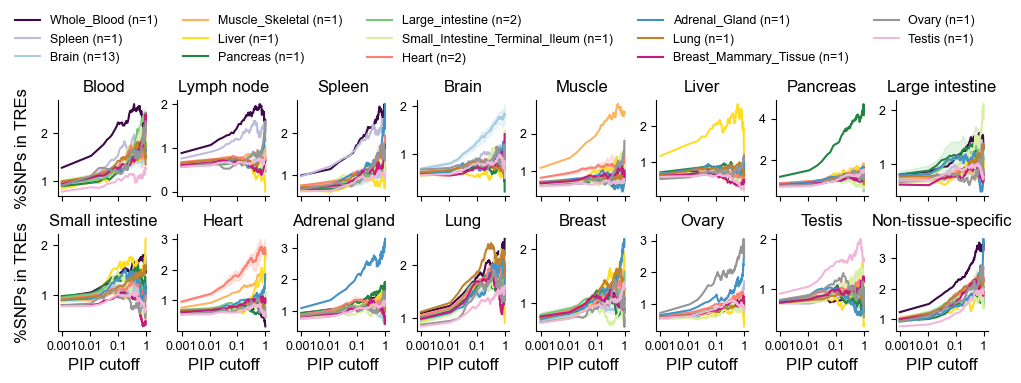

In [70]:
nrow = 2
ncol = 8
hue_order = [f"{k} (n={len(trait_groups[data_type][k])})" for k in trait_groups[data_type]]
palette = [cdict[" ".join(group_mapping[t].split("_"))] for t in list(trait_groups["eQTL"]) if t != "Other"]
fig, axes = plt.subplots(nrow, ncol, figsize=(12, 3))
for t in ts:
	row = ts.index(t) // ncol
	col = ts.index(t) % ncol
	ax = axes[row, col]
	title = " ".join(t.split("_")) if t != "Non_tissue_specific" else "Non-tissue-specific"
	xlabel = True if row == nrow-1 else False
	ylabel = True if col == 0 else False
	legend = True if row == 0 and col == 3 else False
	plot_individual_curve_TRE_centric(df_props2[(data_type, t, method)], hue_order, palette, 
						  ax, title, xlabel, ylabel, legend)
fig.subplots_adjust(hspace=0.4, wspace=0.3)

plt.savefig(f"{PROJECT_DIR_o2}figures/ExtDataFig7c.pdf", bbox_inches='tight', transparent=True)

## GWAS

In [72]:
inputfile = f"{PROJECT_DIR_d2}papers/38014075/GWAS/UKBB_94traits_release1.traits"
df_traits = pd.read_table(inputfile)
df_traits.head(2)

,cohort,trait,description,definition,n,n_cases,n_controls
0,UKBB,AFib,Atrial fibrillation,Phecode 427.2,349512,12975.0,336537.0
1,UKBB,AG,Albumin/Globulin ratio,Albumin (30600) / (Total Protein [30860] - Alb...,316549,NaN,NaN


In [73]:
traits_mapping = {}
for _, row in df_traits.iterrows():
	traits_mapping[row["trait"]] = row["description"]

In [74]:
data_type = "GWAS"
df_props_traits = {}
traits = [k for k, v in sorted(traits_mapping.items(), key=lambda x: x[1])]
for method in methods:
	for trait in traits:
		dfs = []
		for t in ts:
			k = (data_type, t, method)
			df = df_props[k][(df_props[k]["n_total"]>=cutoff) & (df_props[k]["trait"]==trait)].copy()
			df["tre_category"] = t
			dfs.append(df)
		df_props_traits[(method, trait)] = pd.concat(dfs)

In [88]:
# Trait-centric
# Each subplot: a GWAS trait
# Each curve: different TRE categories

def plot_individual_curve_trait_centric(df, hue_order, palette, ax, title, xlabel=True, ylabel=True, legend=True):
	g = sns.lineplot(data=df, x="cutoff", y="prop", errorbar="se", hue="tre_category", 
					 hue_order=hue_order, palette=palette, ax=ax)
	g.set_title(title, fontsize=bfontsize)
	g.spines[["top","right"]].set_visible(False)

	if legend:
		g.legend(title="TRE category", title_fontsize=sfontsize, loc="upper left", 
				 bbox_to_anchor=(0.1,0.9), fontsize=sfontsize, frameon=False)
	else:
		g.legend([],[],frameon=False)
		
	g.set_xscale('log')
	g.set_xticks([0.001, 0.01, 0.1, 1])
	if xlabel:
		g.set_xlabel('PIP cutoff', fontsize=bfontsize)
		g.set_xticklabels(["0.001", "0.01", "0.1", "1"])
	else:
		g.set_xlabel("")
		g.set_xticklabels([])
	if ylabel:
		g.set_ylabel('%SNPs in TREs', fontsize=bfontsize)
	else:
		g.set_ylabel("")
	
	g.tick_params(labelsize=sfontsize)

In [82]:
# Highlight one trait in main figure
# Only show the tissue-specific and others

trait = "Alb"
t = "Liver"
df_renamed = df_props_traits[(method, trait)].copy()
df_renamed["tre_category"] = np.where(df_renamed["tre_category"] == t, f"{t}-specific", "Others")
df_renamed.head(2)

,cutoff,trait,n_total,n_in_tre,prop,tre_category
3900,0.001000,Alb,17113,241,1.408286,Others
3901,0.011091,Alb,4868,72,1.479047,Others


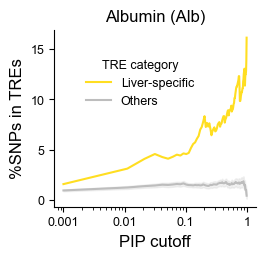

In [89]:
fig, ax = plt.subplots(figsize=(2.6,2.3))
hue_order_renamed = [f"{t}-specific", "Others"]
palette_renamed = [cdict[t], "#bdbdbd"]
plot_individual_curve_trait_centric(df_renamed, hue_order_renamed, palette_renamed, ax, f"{traits_mapping[trait]} ({trait})")
# plt.savefig(f"{PROJECT_DIR_o2}figures/Fig4b.pdf", bbox_inches='tight', transparent=True)